In [1]:
import pandas as pd
import scipy.sparse
import sqlite3
import pickle
from gensim.models import KeyedVectors

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from scipy.interpolate import make_interp_spline, BSpline
import scipy as sp

from tqdm import tqdm
from time import perf_counter

import utils

%matplotlib inline

In [41]:
sql_db = './data/film_discussions'
conn = sqlite3.connect(sql_db)

## Apply names to topics
Note: names manually created in a csv file based on an interpretation of the 25 terms most similar to the topic. I also made a few very rough categorizations, the most important one of which is 'politics'.

In [8]:
topics = pd.read_csv('data/atom_topic_names.csv', sep=';')

# Sort topics as text (0,1,10,100,101...11...2) because that's how the columns of the atom matrix are ordered
topics['DATM'] = topics['DATM'].astype(str)
topics = topics.sort_values('DATM')

print(topics.head())

names = topics['Name'].tolist()

pol_names = topics["Name"][topics["Category"] == "Politics"].tolist()

    DATM                             Name Category
233    0               Unlikable behavior    Human
121    1  Kingdoms, kings and underworlds     Film
218   10                     Superlatives  Grammar
216  100                 Strong reactions    Other
22   101                        Bodyparts  Grammar


In [9]:
atom_mat = scipy.sparse.load_npz('data/ngram_atoms.npz')
atoms = atom_mat.todense()
#atoms = pd.DataFrame.sparse.from_spmatrix(atom_mat, columns=names)
atoms = pd.DataFrame(atoms, columns=names)

In [10]:
atoms.head()

,Unlikable behavior,"Kingdoms, kings and underworlds",Superlatives,Strong reactions,Bodyparts,Female actors,Will,Remembering,Male actors 2,Doesn't,...,Berating,Have,Male names,Shit and assholes,Measurements,Extremely,Latin words,Names,Terrified and sociopathic,Occurrence in sequence
0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.014851,0.0,0.009901,0.0,0.004950,0.00495,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.014286,0.0,0.009524,0.0,0.004762,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.046512,0.0,0.000000,0.00000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
atoms.head().sum(axis=1)

0    1.0
1    0.0
2    1.0
3    1.0
4    1.0
dtype: float64

## Append the topic loadings to sql database

In [13]:
comments = pd.read_csv('data/comments.csv', sep=';')

In [17]:
comment_ids = comments["comment_id"].to_list()

In [18]:
atoms["comment_id"] = comment_ids

In [ ]:
# This gave an error but did create the table with column names
atoms.to_sql("topic_scores", conn, chunksize=10000)
# Optimal chunksize is 10,000 according to https://acepor.github.io/2017/08/03/using-chunksize/

In [54]:
chunksize = 9999
n_columns = len(atoms.columns)
start = 0

with tqdm(total=len(atoms)) as pbar:
    data = [tuple(x) for x in atoms.loc[start:chunksize].to_numpy()]
    while len(data) > 0: 
        with conn:
            n_rows = utils.add_rows(conn, 'topic_scores', n_columns, data)
            
        start = start+chunksize+1
        end = start+chunksize
        
        try:
            data = [tuple(x) for x in atoms.loc[start:end].to_numpy()]
        except:
            try:
                data = [tuple(x) for x in atoms.loc[start:].to_numpy()]
            except:
                data = None
                
        pbar.update(n_rows)

100%|██████████████████████████████████████████████████████████████████████| 2118317/2118317 [06:39<00:00, 5297.46it/s]


## Overview document topics

In [3]:
with open('./datm_ngrams/250comp5nonzeros_dictionary','rb') as f:
    mydictionary=pickle.load(f)

In [6]:
currentmodel = KeyedVectors.load('./models/gensim_model_window7_vector_300')

In [27]:
topics['Most similar tokens'] = None

In [28]:
topics['DATM'] = topics['DATM'].astype(int)
topics.set_index('DATM', inplace=True)

In [30]:
topics.sort_index(inplace=True)

In [32]:
for i in range(0, len(mydictionary)):
    most_sim = [j for j in currentmodel.wv.similar_by_vector(mydictionary[i],topn=25)]
    
    topics.at[i,'Most similar tokens'] = most_sim

In [33]:
topics.head()

,Name,Category,Most similar tokens
DATM,,,
0,Unlikable behavior,Human,"[(fantasising, 0.7166740298271179), (bragged, ..."
1,"Kingdoms, kings and underworlds",Film,"[(poseidon, 0.6350440979003906), (kingdom, 0.6..."
2,Likable personalities,Human,"[(sophisticated, 0.6821580529212952), (relatea..."
3,Voice and body language,Human,"[(voice, 0.6441890597343445), (mannerisms, 0.6..."
4,Film length and description,Film,"[(90_minute, 0.6584582328796387), (feature_len..."


In [39]:
topics.to_csv('output/topics.csv')

## Collect data from the database

In [42]:
t1_start = perf_counter()  

sql = """
    SELECT submissions.title, submissions.num_comments, submissions.created, 
    AVG(topic_scores."Extreme political identities") AS "Pol_identity"
    FROM comments
    INNER JOIN topic_scores ON comments.comment_id = topic_scores.comment_id
    INNER JOIN submissions ON comments.submission_id = submissions.submission_id
    GROUP BY submissions.submission_id;
    """

grouped = pd.read_sql(sql, conn)

print(perf_counter()-t1_start)

197.94499640000004


In [194]:
sql = "SELECT submissions.title, submissions.num_comments, submissions.created, "

for i in pol_names:
    k = i.replace(' ', '_')
    j = f' AVG(topic_scores."{i}") AS "{k}",'
    sql = sql+j
    
sql = sql[:-1] + " FROM comments INNER JOIN topic_scores ON comments.comment_id = topic_scores.comment_id INNER JOIN submissions ON comments.submission_id = submissions.submission_id GROUP BY submissions.submission_id;"

print(sql)

SELECT submissions.title, submissions.num_comments, submissions.created,  AVG(topic_scores."Extreme political identities") AS "Extreme_political_identities", AVG(topic_scores."Forms of government") AS "Forms_of_government", AVG(topic_scores."Wealthy and introverted") AS "Wealthy_and_introverted", AVG(topic_scores."Harassing, raping and murdering") AS "Harassing,_raping_and_murdering", AVG(topic_scores."Political issues") AS "Political_issues", AVG(topic_scores."Social and cultural") AS "Social_and_cultural", AVG(topic_scores."Contrarian arguing, narrowmindedness") AS "Contrarian_arguing,_narrowmindedness", AVG(topic_scores."Political and racial identities") AS "Political_and_racial_identities" FROM comments INNER JOIN topic_scores ON comments.comment_id = topic_scores.comment_id INNER JOIN submissions ON comments.submission_id = submissions.submission_id GROUP BY submissions.submission_id;


In [195]:
grouped = pd.read_sql(sql, conn)

In [196]:
grouped['date'] = pd.to_datetime(grouped['created'], unit='s') #.dt.date

In [198]:
grouped.sort_values('Extreme_political_identities', ascending=False).head(10)

,title,num_comments,created,Extreme_political_identities,Forms_of_government,Wealthy_and_introverted,"Harassing,_raping_and_murdering",Political_issues,Social_and_cultural,"Contrarian_arguing,_narrowmindedness",Political_and_racial_identities,date
984,Official Discussion - Moxie [SPOILERS],175,1614971128,0.024246,0.008938,0.002917,0.005450,0.002953,0.028642,0.004218,0.012796,2021-03-05 19:05:28
804,Official Discussion: Black Christmas [SPOILERS],423,1576206029,0.020419,0.002242,0.000865,0.001212,0.000818,0.016162,0.008385,0.019043,2019-12-13 03:00:29
76,Official Discussion: Dear White People [SPOILERS],207,1414205548,0.019298,0.020119,0.000412,0.010551,0.001751,0.034785,0.014480,0.033862,2014-10-25 02:52:28
882,Official Discussion - Black is King [SPOILERS],303,1596199386,0.016486,0.046408,0.001418,0.002939,0.001024,0.029566,0.022547,0.020607,2020-07-31 12:43:06
201,Official Discussion: Chi-Raq [SPOILERS],49,1449285175,0.016342,0.016321,0.000381,0.013268,0.005434,0.035893,0.015679,0.020978,2015-12-05 03:12:55
253,Official Discussion - Barbershop: The Next Cut...,138,1460769571,0.015132,0.006134,0.000000,0.003088,0.003882,0.017838,0.011837,0.019357,2016-04-16 01:19:31
1094,Official Discussion - There's Someone Inside Y...,103,1633658366,0.015061,0.005697,0.004486,0.005161,0.001045,0.005121,0.003219,0.003032,2021-10-08 01:59:26
267,Official Discussion - Neighbors 2: Sorority Ri...,207,1463712543,0.013848,0.003673,0.000628,0.001002,0.000806,0.004795,0.002335,0.005549,2016-05-20 02:49:03
806,Official Discussion: Richard Jewell [SPOILERS],866,1576267220,0.012879,0.011207,0.001168,0.001021,0.001933,0.011564,0.006551,0.005910,2019-12-13 20:00:20
686,Official Discussion: Little [SPOILERS],75,1555034424,0.012711,0.001770,0.000487,0.000357,0.000213,0.006102,0.009264,0.008440,2019-04-12 02:00:24


<AxesSubplot:xlabel='date'>

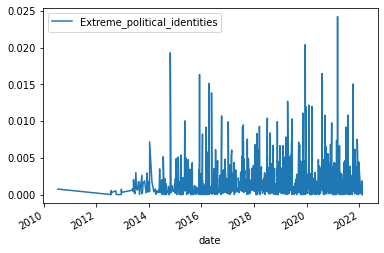

In [199]:
grouped.plot.line(x='date', y='Extreme_political_identities')

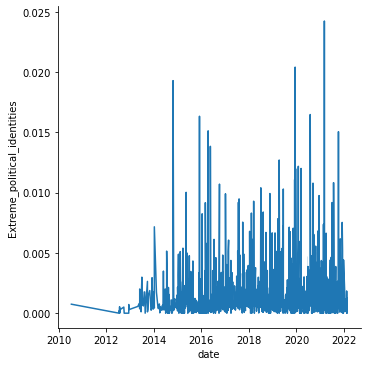

In [200]:
sns.relplot(x="date", y="Extreme_political_identities", kind="line", data=grouped)

In [201]:
grouped.set_index('date', inplace=True)

In [202]:
grouped.groupby(pd.Grouper(freq='YS', convention="start")).count()

,title,num_comments,created,Extreme_political_identities,Forms_of_government,Wealthy_and_introverted,"Harassing,_raping_and_murdering",Political_issues,Social_and_cultural,"Contrarian_arguing,_narrowmindedness",Political_and_racial_identities
date,,,,,,,,,,,
2010-01-01,1,1,1,1,1,1,1,1,1,1,1
2011-01-01,0,0,0,0,0,0,0,0,0,0,0
2012-01-01,13,13,13,13,13,13,13,13,13,13,13
2013-01-01,25,25,25,25,25,25,25,25,25,25,25
2014-01-01,58,58,58,58,58,58,58,58,58,58,58
2015-01-01,124,124,124,124,124,124,124,124,124,124,124
2016-01-01,134,134,134,134,134,134,134,134,134,134,134
2017-01-01,130,130,130,130,130,130,130,130,130,130,130
2018-01-01,162,162,162,162,162,162,162,162,162,162,162


In [203]:
g = grouped.groupby(pd.Grouper(freq='YS')).mean()

In [204]:
g

,num_comments,created,Extreme_political_identities,Forms_of_government,Wealthy_and_introverted,"Harassing,_raping_and_murdering",Political_issues,Social_and_cultural,"Contrarian_arguing,_narrowmindedness",Political_and_racial_identities
date,,,,,,,,,,
2010-01-01,255.000000,1.279319e+09,0.000747,0.001312,0.000235,0.000912,0.000398,0.004542,0.001560,0.001345
2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2012-01-01,519.076923,1.347466e+09,0.000242,0.003288,0.000751,0.001075,0.000071,0.004334,0.003827,0.001674
2013-01-01,544.440000,1.378291e+09,0.001034,0.002519,0.001051,0.001467,0.000304,0.005936,0.003811,0.002846
2014-01-01,947.482759,1.407031e+09,0.001181,0.003042,0.000690,0.001054,0.000520,0.006084,0.003329,0.002752
2015-01-01,1017.137097,1.436659e+09,0.001249,0.002931,0.000810,0.001099,0.000558,0.005059,0.003550,0.002558
2016-01-01,1433.313433,1.467138e+09,0.001483,0.003099,0.000712,0.001089,0.000592,0.005781,0.003904,0.002737
2017-01-01,3007.823077,1.499375e+09,0.001552,0.003307,0.000795,0.001176,0.000585,0.006192,0.003908,0.002939
2018-01-01,2379.796296,1.532361e+09,0.001570,0.003500,0.000787,0.001324,0.000740,0.006182,0.003619,0.003120


In [205]:
h = g[(g.index > pd.Timestamp(2013, 1, 1)) & (g.index < pd.Timestamp(2022, 1, 1))]

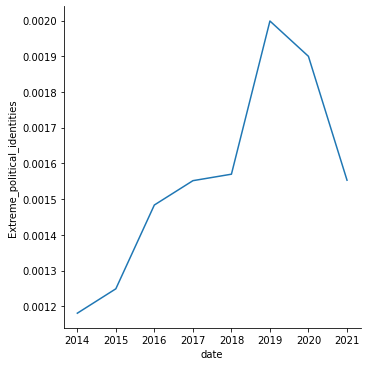

In [206]:
sns.relplot(x=h.index, y="Extreme_political_identities", data=h, kind="line")

In [209]:
pol_names_b = [i.replace(' ', '_') for i in pol_names]

In [222]:
df = pd.melt(h.reset_index(), id_vars='date', value_vars=pol_names_b, var_name="Topic", value_name="Mean")

In [247]:
df = df.sort_values("Mean", ascending=False)

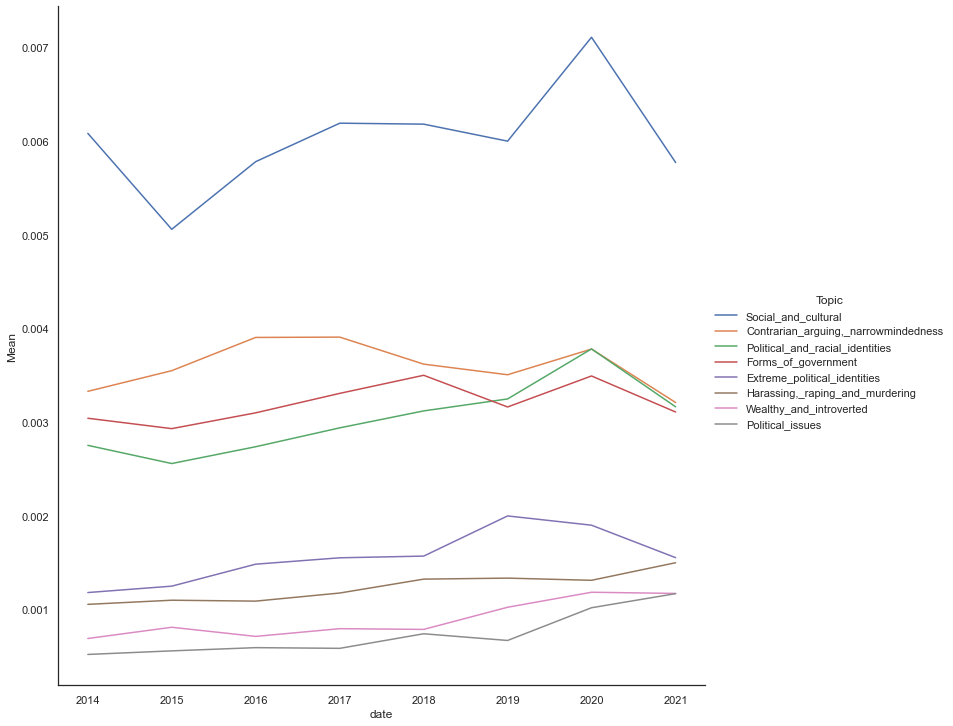

In [265]:
sns.relplot(x='date', y="Mean", hue="Topic", data=df, kind="line", height=10)